In [1]:
%load_ext autoreload
%autoreload 

import sys
import os
classes_path = os.path.abspath('../h5tests/')
sys.path.append(classes_path)
from h5py_arr_mean import H5pyArrMean
import pandas as pd

benchmarks = []

In [2]:
original_granules = [
    "s3://its-live-data/cloud-experiments/h5cloud/atl03/big/original/ATL03_20181120182818_08110112_006_02.h5",
    "s3://its-live-data/cloud-experiments/h5cloud/atl03/big/original/ATL03_20190219140808_08110212_006_02.h5",
]
h5py_original = H5pyArrMean('atl03-bigsize-original', files=original_granules, store_results=True)

In [3]:
# takes about ~30 seconds per granule out of region (6+ GB granules)
io_params ={
    "fsspec_params": {},
    "h5py_params" : {}
}
results = h5py_original.run(io_params)
benchmarks.append({"library": "h5py",
                   "format": "original",
                   "mean": results[0],
                   "time": results[1],
                   "total_requested_bytes": results[3]["total_reqs_bytes"],
                   "total_requests": results[3]["total_reqs"],
                   "avg_req_size": results[3]["avg_req_size"]})
benchmarks

h5py params:  {}
h5py params:  {}


[{'library': 'h5py',
  'format': 'original',
  'mean': 1032.9840463639412,
  'time': 51.46329092979431,
  'total_requested_bytes': 414028873,
  'total_requests': 12295,
  'avg_req_size': 33674}]

In [4]:
cloud_optimized_granules = [
    "s3://its-live-data/cloud-experiments/h5cloud/atl03/big/repacked/ATL03_20181120182818_08110112_006_02_repacked.h5",
    "s3://its-live-data/cloud-experiments/h5cloud/atl03/big/repacked/ATL03_20190219140808_08110212_006_02_repacked.h5",
]
h5py_cloud = H5pyArrMean('atl03-bigsize-repacked', files=cloud_optimized_granules, store_results=True)

In [5]:
# takes about ~30 seconds per granule out of region
io_params ={
    "fsspec_params": {
        # "skip_instance_cache": True
        "cache_type": "first",
        "block_size": 16*1024*1024
    },
    "h5py_params" : {
        "page_buf_size": 32*1024*1024,
        "rdcc_nbytes": 1024*1024
    }
}

results = h5py_cloud.run(io_params)

benchmarks.append({"library": "h5py",
                   "format": "cloud",
                   "mean": results[0],
                   "time": results[1],
                   "total_requested_bytes": results[3]["total_reqs_bytes"],
                   "total_requests": results[3]["total_reqs"],
                   "avg_req_size": results[3]["avg_req_size"]})
benchmarks

h5py params:  {'page_buf_size': 33554432, 'rdcc_nbytes': 1048576}
h5py params:  {'page_buf_size': 33554432, 'rdcc_nbytes': 1048576}


[{'library': 'h5py',
  'format': 'original',
  'mean': 1032.9840463639412,
  'time': 51.46329092979431,
  'total_requested_bytes': 414028873,
  'total_requests': 12295,
  'avg_req_size': 33674},
 {'library': 'h5py',
  'format': 'cloud',
  'mean': 1032.9840463639412,
  'time': 42.97014808654785,
  'total_requested_bytes': 560001136,
  'total_requests': 78,
  'avg_req_size': 7179501}]

In [6]:
df = pd.DataFrame.from_dict(benchmarks)
df

,library,format,mean,time,total_requested_bytes,total_requests,avg_req_size
0,h5py,original,1032.984046,51.463291,414028873,12295,33674
1,h5py,cloud,1032.984046,42.970148,560001136,78,7179501


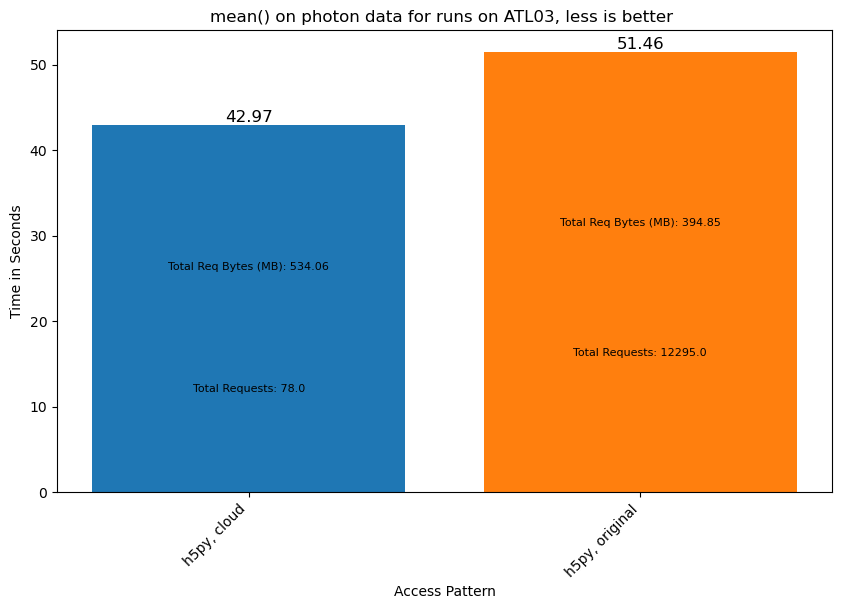

<Figure size 640x480 with 0 Axes>

In [7]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))

for name, group in df.groupby(['library', 'format']):
    library, format = name
    x = f'{library}, {format}'
    y = group['time'].mean()
    ax.bar(f'{library}, {format}', group['time'].mean(), label=f'{library}, {format}', align='center')
    ax.text(x, y + 0.05, f'{group["time"].mean():.2f}', ha='center', va='bottom', color='black', fontsize=12)
    ax.text(x, y - (y/2) - 10, f'Total Requests: {group["total_requests"].mean()}', ha='center', va='bottom', color='black', fontsize=8)
    ax.text(x, y - (y/2.5), f'Total Req Bytes (MB): {round(group["total_requested_bytes"].mean() / (1024*1024) , 2)}', ha='center', va='bottom', color='black', fontsize=8)

# Set labels and title
ax.set_xlabel('Access Pattern')
ax.set_ylabel('Time in Seconds')
ax.set_title(f'mean() on photon data for runs on ATL03, less is better ')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# # Show legend
# ax.legend()

# Show the plot
with plt.xkcd():
    # This figure will be in XKCD-style
    fig1 = plt.figure()